In [23]:
import numpy as np
import matplotlib.pyplot as plt

class Board(object):
    '''
    Basic Implementation of a ToricGame Board, actions are int [0,2*board_size**2)
    q : qubit
    P : plaquette operator

    ---q-------q-------q---
    |      |       |
    q  P   q   P   q   P
    |      |       |
    |--q-------q-------q---
    |      |       |
    q  P   q   P   q   P
    |      |       |
    |--q-------q-------q---
    |      |       |
    q  P   q   P   q   P
    |      |       |

    '''
    @staticmethod
    def component_positions(size):
        qubit_pos   = [[x,y] for x in range(2*size) for y in range((x+1)%2, 2*size, 2)]
        plaquet_pos = [[x,y] for x in range(1,2*size,2) for y in range(1,2*size,2)]

        return qubit_pos, plaquet_pos

    def __init__(self, board_size):
        self.size = board_size

        # Real-space locations
        self.qubit_pos, self.plaquet_pos  = self.component_positions(self.size)

        # Define here the logical error for efficiency
        self.left_boundary_positions = [[0,x] for x in range(1, 2*self.size, 2)]        
        self.bottom_boundary_position = [[1,x] for x in range(0, 2*self.size, 2)]
    
        self.reset()

    def reset(self):
        self.qubit_values = np.zeros((2*self.size*self.size))
        self.op_values = np.zeros((2, self.size*self.size))
        self.syndrome_pos = [] # Location of syndromes
        
    def adjacent_plaquettes(self, coord):
        '''Find plaquettes that the flipped qubit is a part of '''
        plaqs = []
        if coord[0] % 2 == 0:
            plaqs += [ [ (coord[0] + 1) % (2*self.size), coord[1] ], [ (coord[0] - 1) % (2*self.size), coord[1] ] ]
        else:
            plaqs += [ [ coord[0], (coord[1] + 1) % (2*self.size) ], [ coord[0], (coord[1] - 1) % (2*self.size) ] ]
        return plaqs

    def act(self, coord):
        '''
            Args: input action in the form of position [x,y]
            coord: real-space location of the qubit to flip
        '''

        qubit_index=self.qubit_pos.index(coord)

        # Flip it!
        self.qubit_values[qubit_index] = (self.qubit_values[qubit_index] + 1) % 2

        # Update the syndrome measurements
        # Only need to incrementally change
        
        # TODO: Write quick test function for this function
        plaqs = self.adjacent_plaquettes(coord)
        
        # Update syndrome positions
        # TODO: Maybe update to boolean list?
        for plaq in plaqs:
            if plaq in self.syndrome_pos:
                self.syndrome_pos.remove(plaq)
            else:
                self.syndrome_pos.append(plaq)

            # The plaquette or vertex operators are only 0 or 1
            # TODO: This is always true?
            if plaq in self.plaquet_pos:
                op_index = self.plaquet_pos.index(plaq)
                channel = 0
        
            self.op_values[channel][op_index] = (self.op_values[channel][op_index] + 1) % 2

    def has_syndrome(self):
        return len(self.syndrome_pos) == 0

    def has_odd_number_of_errors_on_boundary(self):
        # TODO: Check!!
        
        # Check for Z logical error
        zerrors = [0,0]
        for pos in self.left_boundary_positions:
            qubit_index = self.qubit_pos.index(pos)
            zerrors[0] += self.qubit_values[ qubit_index ]

        for pos in self.bottom_boundary_positions:
            qubit_index = self.qubit_pos.index(pos)
            zerrors[1] += self.qubit_values[ qubit_index ]

        if (zerrors[0]%2 == 1) or (zerrors[1]%2 == 1):
            return True

        return False

    def __repr__(self):
        ''' representation of the board class
            print out board_state
        '''
        return f"Qubit Values: {self.qubit_values}, Operator values: {self.op_values}"

    def encode(self, channels, memory):
        ''' Return: np array
            np.array(board_size, board_size): state observation of the board
        '''
        # In case of uncorrelated noise for instance, we don't need information
        # about the star operators

        img=np.array([])
        img = np.concatenate((img, self.op_values[0]))
        if memory:
            img = np.concatenate((img, self.qubit_values[0]))

        return img
    
    def render(self):
        fig, ax = plt.subplots()
        a=1/(2*self.size)

        for i, p in enumerate(self.plaquet_pos):
            if self.op_values[0][i]==1:
                fc='darkorange'
                plaq = plt.Polygon([[a*p[0], a*(p[1]-1)], [a*(p[0]+1), a*(p[1])], [a*p[0], a*(p[1]+1)], [a*(p[0]-1), a*p[1]] ], fc=fc)
                ax.add_patch(plaq)

        # Draw lattice
        for x in range(self.size):
            for y in range(self.size):
                pos=(2*a*x, 2*a*y)
                width=a*2
                lattice = plt.Rectangle( pos, width, width, fc='none', ec='black' )
                ax.add_patch(lattice)

        for i, p in enumerate(self.qubit_pos):
            pos=(a*p[0], a*p[1])
            fc='darkgrey'
            if self.qubit_values[i] == 1:
                fc='darkblue'
            elif self.qubit_values[i] == 0:
                fc='darkred'
            circle = plt.Circle( pos , radius=a*0.25, ec='k', fc=fc)
            ax.add_patch(circle)
            plt.annotate(str(i), pos, fontsize=8, ha="center")

        ax.set_xlim([-.1,1.1])
        ax.set_ylim([-.1,1.1])
        ax.set_aspect(1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis('off')
        plt.show()

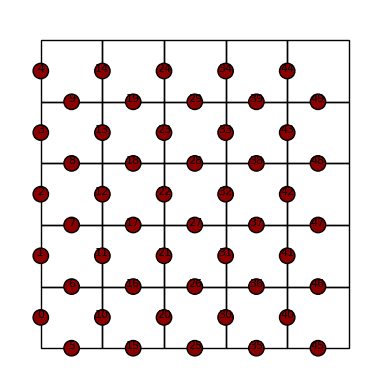

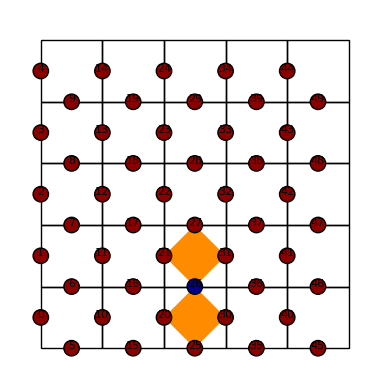

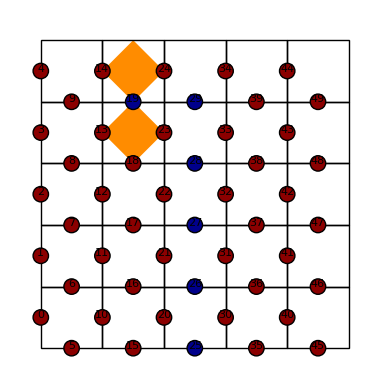

False
[[3, 9], [3, 7]]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [33]:
board = Board(5)
board.render()

board.act([5,2])
board.render()

board.act([5,4])
board.act([5,0])
board.act([5,6])
board.act([5,8])


board.act([3,8])

board.render()

print(board.is_terminal())


print(board.syndrome_pos)
print(board.op_values[0])